# Tutorial on Computational Discovery of Cognitive Dynamics

This tutorial will lead you step-by-step into the world of computational discovery of cognitive dynamics.

In this tutorial you will learn to:

1. set up a data generation pipeline using a `Bandit` environment and a Q-Learning `Agent`

2. create your own RNN with different neural-network modules of which each approximates subsets of cognitive mechanisms and fit them to the generated data

3. apply SINDy to replace the neural-network modules with equations for dynamical systems

In order to get everything going make sure to setup an environment with Python 3.11 and install the packages from the requirements. 

In [1]:
import sys, os

# Get the current working directory (where the notebook is running)
dir_current = os.getcwd()

# Define the path to the project directory
dir_project = os.path.join(dir_current, "..")

# Add the project directoy to the Python path to make the subpackages visible
sys.path.append(dir_project)

## 1. Data generation

Let's get started by setting up a two-armed bandit experiment and let a Q-Learning agent perform this task.

In such bandit tasks the participant has to choose between several options across many trials and receives a reward $r$ each time after selecting one of them.

This reward is based on a reward probability $p(r)$.

In some experiments the reward probabilities of the different options are fixed and in others they have a more dynamic nature.

In our case, the reward probabilities are going to change trial-by-trial randomly based on a drift rate $\sigma$ according to

$p(r;t+1) \leftarrow p(r;t) + d$ with $d \sim \mathcal{N}(0, \sigma)$,

where $d$ is the current drift.

Let's set up the environment first.

In [2]:
from resources.bandits import BanditsDrift

In [3]:
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

In [4]:
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

Let's see how the reward probabilities of the arms change across trials

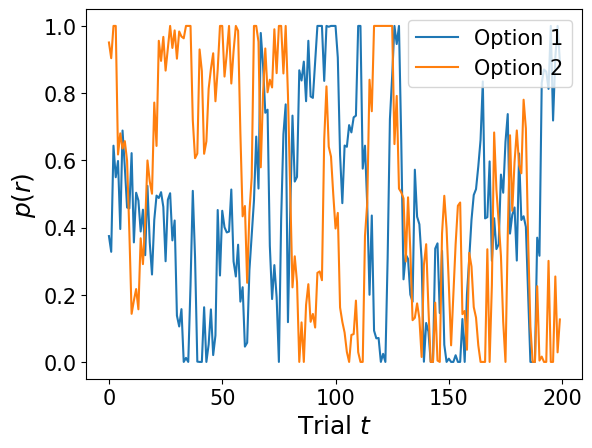

In [5]:
import numpy as np
import matplotlib.pyplot as plt

n_trials = 200
reward_probabilities = np.zeros((n_trials, n_actions))

for index_trials in range(n_trials):
    reward_probabilities[index_trials] = environment.reward_probs
    environment.step(choice=0)

for index_action in range(n_actions):
    plt.plot(reward_probabilities[..., index_action], label=f'Option {index_action+1}')
plt.legend()
plt.xlabel(r'Trial $t$')
plt.ylabel(r'$p(r)$')
plt.show()

Great! After setting up the environment, we can now go on to set up our participant!

The agent's behavior is defined by its parameters. These parameters are set once in the beginning but you can also draw new parameters from a distribution for each new session (i.e. performing $t$ trials).

Let's begin with the simpler case first and keep the parameters fixed for all trials.

We are going to set up a simple Rescorla-Wagner model which has only a learning rate $\alpha$ and an inverse noise temperature $\beta_{reward}$.

In [6]:
from resources.bandits import AgentQ

agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.3,
)

Let the agent perform now the task and track how the agent's internal believes change across trials!

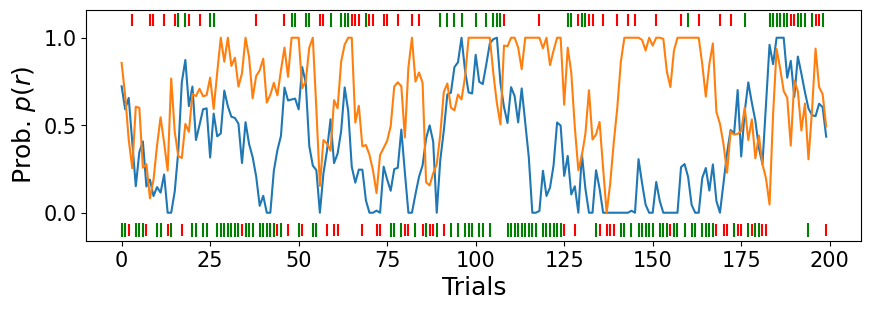

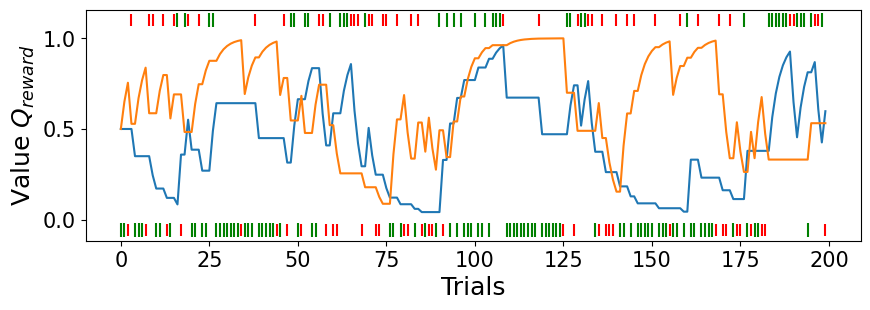

In [7]:
from resources.bandits import plot_session

values_reward = np.zeros((n_trials, n_actions))
choices = np.zeros((n_trials,), dtype=int)
rewards = np.zeros((n_trials, n_actions))
rewards_1d = np.zeros((n_trials))

environment.new_sess()
agent.new_sess()
for index_trials in range(n_trials):
    # track internal values of the agent and the reward probabilities
    values_reward[index_trials] = agent._state['x_value_reward']
    reward_probabilities[index_trials] = environment.reward_probs
    
    # perform the task
    choices[index_trials] = agent.get_choice()
    rewards[index_trials] = environment.step(choices[index_trials])
    rewards_1d[index_trials] = rewards[index_trials, choices[index_trials]]
    
    # update the belief of the agent based on the received reward
    agent.update(choices[index_trials], rewards[index_trials])

# plot everyting
plot_session(
    choices=choices,
    rewards=rewards_1d,
    timeseries=reward_probabilities,
    timeseries_name=r'Prob. $p(r)$'
    )

plot_session(
    choices=choices,
    rewards=rewards_1d,
    timeseries=values_reward,
    timeseries_name=r'Value $Q_{reward}$'
    )

The green and red ticks at the bottom mark whenever option 1 was chosen and rewarded/not rewarded and the ticks at the top do the same for option 2

Now that we have set up our experiment and the agent correctly, we can finally create the data generation pipeline!

In [8]:
from resources.bandits import create_dataset

n_sessions = 256

dataset, experiments, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

You can take a look at the experiment results either in dataset (which is used for training the RNN) or in the experiments (which is a list of performed sessions; more human-readable)

In [9]:
print('Inputs (prev. choice; prev. reward; session id):')
print(dataset.xs)

print('Targets (next choice):')
print(dataset.ys)

print('Experiment session:')
print('Choices:')
print(experiments[0].choices)
print('Rewards:')
print(experiments[0].rewards)

Inputs (prev. choice; prev. reward; session id):
tensor([[[  1.,   0.,   1.,  -1.,   0.],
         [  1.,   0.,   1.,  -1.,   0.],
         [  0.,   1.,  -1.,   0.,   0.],
         ...,
         [  0.,   1.,  -1.,   1.,   0.],
         [  0.,   1.,  -1.,   1.,   0.],
         [  0.,   1.,  -1.,   1.,   0.]],

        [[  1.,   0.,   1.,  -1.,   1.],
         [  1.,   0.,   0.,  -1.,   1.],
         [  1.,   0.,   0.,  -1.,   1.],
         ...,
         [  0.,   1.,  -1.,   0.,   1.],
         [  1.,   0.,   1.,  -1.,   1.],
         [  1.,   0.,   1.,  -1.,   1.]],

        [[  0.,   1.,  -1.,   0.,   2.],
         [  0.,   1.,  -1.,   1.,   2.],
         [  1.,   0.,   1.,  -1.,   2.],
         ...,
         [  0.,   1.,  -1.,   1.,   2.],
         [  0.,   1.,  -1.,   0.,   2.],
         [  1.,   0.,   0.,  -1.,   2.]],

        ...,

        [[  1.,   0.,   0.,  -1., 253.],
         [  0.,   1.,  -1.,   0., 253.],
         [  0.,   1.,  -1.,   0., 253.],
         ...,
         [  0.

Now that we have our data, we can proceed to setup our RNN and train it!

## 2. Set up the RNN

In this section you are going to set up your very own RNN. 

This RNN will inherit from the `BaseRNN`-class which itself inherits from `pytorch.nn.Module`. This is the base class for neural networks in the `PyTorch` framework.

Therefore the RNN has to implement a `forward`-method which is used for prediction. Further, it needs submodules to perform computations. These submodules are stored in the dictionary ` submodules_rnn` with the key `x_ModuleName`. The start of the key `x_` means that we are talking here about a memory state variable of the RNN.

Here, we are going to implement the simplest version of such a RNN. This RNN will update only chosen value based on the reward and leaves the respectively other values untouched.

In [10]:
from resources.rnn import BaseRNN

class RLRNN(BaseRNN):
    
    # set up a dictionary with initial values for each state in memory
    init_values = {
        'x_value_reward': 0.5,
    }
    
    def __init__(
        self,
        n_actions,
        **kwargs,
    ):   
        super(RLRNN, self).__init__(n_actions=n_actions, hidden_size=8, list_signals=['x_value_reward', 'c_action', 'c_reward'])
        
        # set up the submodules
        self.submodules_rnn['x_value_reward'] = self.setup_module(input_size=2, hidden_size=self._hidden_size, dropout=0.)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _ = inputs
        
        value_reward = self.get_state()['x_value_reward']
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # Let's perform the belief update for the reward-based value of the chosen option
            # since all values are given to the rnn-module (independent of each other), the chosen value is selected by setting the action to the chosen one
            # if we would like to perform a similar update by calling a rnn-module for the non-chosen action, we would set the parameter to action=1-action.
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward',
                key_state=value_reward,
                action=action,
                inputs=reward,
                )

            # and keep the value of the not-chosen option unchanged
            next_value_reward_not_chosen = value_reward * (1-action)
            
            value_reward = next_value_reward_chosen + next_value_reward_not_chosen
            
            # Now keep track of this value in the output array
            logits[timestep] = value_reward
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        self.state['x_value_reward'] = value_reward
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

Now that we implemented our RNN, we can train it to see how well it fits the behavior of our synthetic participant.

In [11]:
from resources.rnn_training import fit_model

model_rnn = RLRNN(n_actions=n_actions)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-3)

model_rnn, _, _ = fit_model(
    model=model_rnn,
    optimizer=optimizer_rnn,
    dataset_train=dataset,
    epochs=128,
    n_steps=16,
)

Epoch 1/128 --- L(Training): 0.7999670; Time: 0.14s; Convergence value: 6.00e-01
Epoch 2/128 --- L(Training): 0.6928682; Time: 0.10s; Convergence value: 3.54e-01
Epoch 3/128 --- L(Training): 0.7432711; Time: 0.07s; Convergence value: 2.02e-01
Epoch 4/128 --- L(Training): 1.5767582; Time: 0.08s; Convergence value: 5.18e-01
Epoch 5/128 --- L(Training): 2.3373996; Time: 0.08s; Convergence value: 6.39e-01
Epoch 6/128 --- L(Training): 3.3480433; Time: 0.08s; Convergence value: 8.25e-01
Epoch 7/128 --- L(Training): 3.9931919; Time: 0.07s; Convergence value: 7.35e-01
Epoch 8/128 --- L(Training): 4.6380022; Time: 0.08s; Convergence value: 6.90e-01
Epoch 9/128 --- L(Training): 5.2932722; Time: 0.07s; Convergence value: 6.73e-01
Epoch 10/128 --- L(Training): 5.9256169; Time: 0.09s; Convergence value: 6.52e-01
Epoch 11/128 --- L(Training): 6.5514133; Time: 0.08s; Convergence value: 6.39e-01
Epoch 12/128 --- L(Training): 7.1683972; Time: 0.08s; Convergence value: 6.28e-01
Epoch 13/128 --- L(Traini

Let's see how our model behaves with respect to our synthetic participant

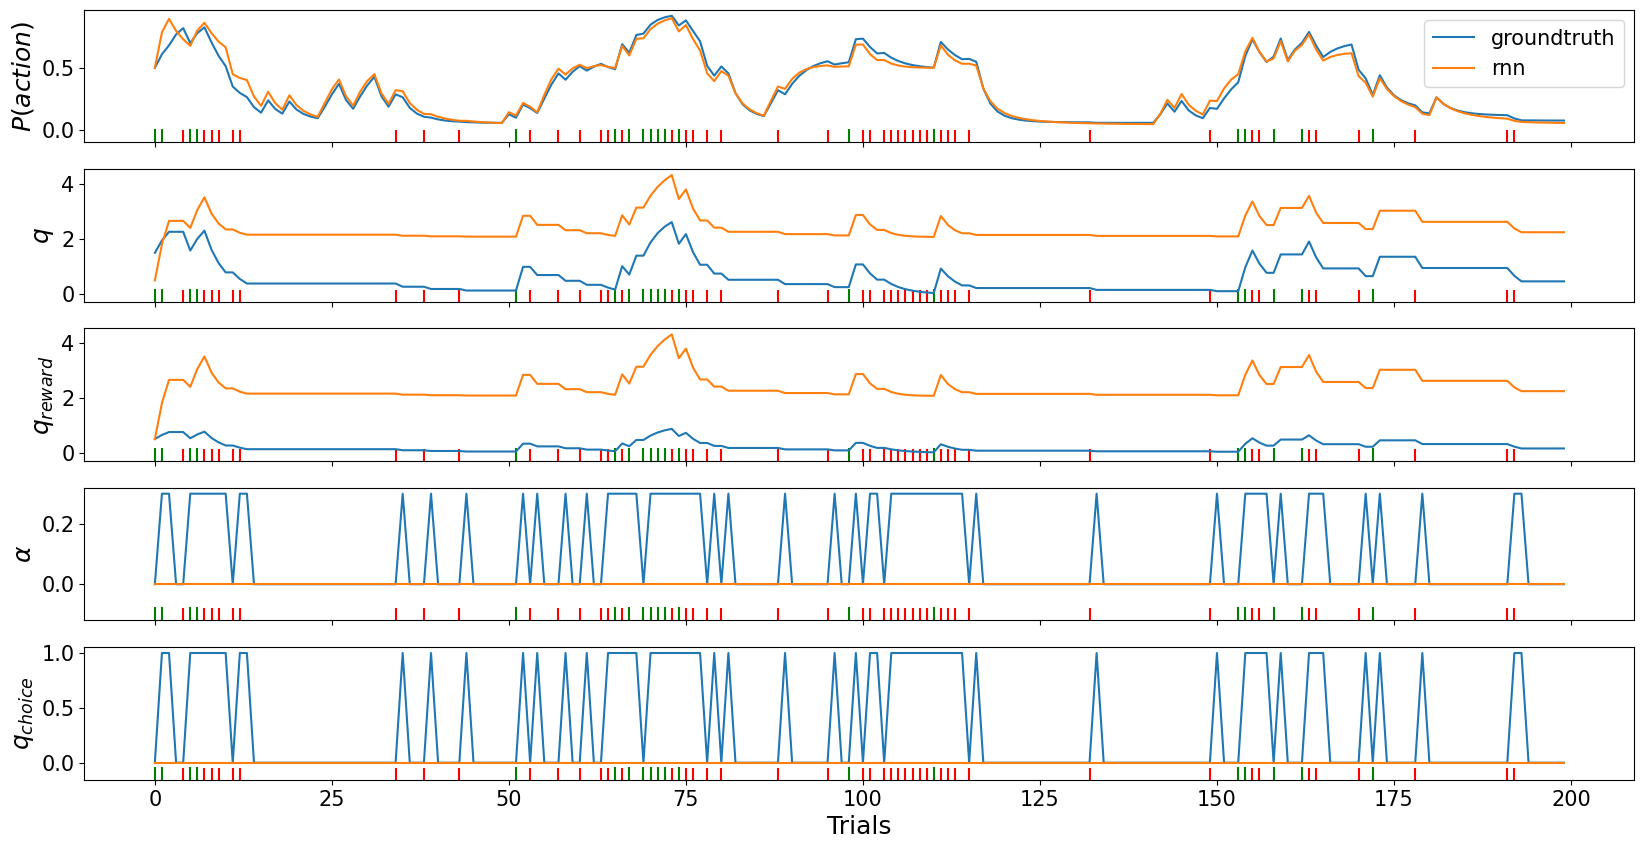

In [12]:
from resources.bandits import AgentNetwork
from utils.plotting import plot_session

kw_args_model = {
    'n_actions': model_rnn._n_actions,
}
agent_rnn = AgentNetwork(model_rnn=model_rnn, n_actions=n_actions)

# get analysis plot
agents = {'groundtruth': agent, 'rnn': agent_rnn}

fig, axs = plot_session(agents, experiments[0])
plt.show()

## 3. Applying SINDy to identify the trained cognitive dynamics

In this section we are going to replace the black-box RNN-modules with equations which cover - in the best case - the dynamics trained by the RNN.

Therefore, we are going to extract the memory state values of interest and fit one SINDy-model per RNN-module, which will then be replaced by its SINDy counterpart.

But before doing that, we have to define the exact architecture in the forms of dictionaries.

In [13]:
# A list of all names of the RNN-modules which are computing the RNN's memory state
list_variables = ['x_value_reward']

# A list of all the control signals which are used as inputs to any of the RNN-modules
list_control_parameters = ['c_action', 'c_reward']

# Setup of the SINDy library
# Determines which terms are allowed as control inputs to each SINDy model in a dictionary.
# The key is the SINDy-model name (same as RNN-module), value is a list of allowed control inputs from the list of control signals     
library_setup = {
    'x_value_reward': ['c_reward'],
}

# Setup of the filtering condition
# Determines the filtering condition on which samples are selected as training samples for each SINDy-model.
# Example:
# Since each RNN-module processes all values at once (but independet from each other), we have to filter for the updates of interest.
# In the case of the reward-based value of the chosen option this means to use only the chosen items and not the non-chosen ones. 
# Therefore, we can set a filter condition to get rid of all value updates for non-chosen options.  
# The filter dictionary has the following structure:
# key -> the SINDy model name
# value -> triplet of values:
#   1. str: feature name to be used as a filter
#   2. numeric: the numeric filter condition
#   3. bool: remove feature from control inputs if not needed as input to the module
# Multiple conditions can also be given as a list of triplets, e.g. [['c_action', 1, True], ['c_reward', 0, False]]

filter_setup = {
    'x_value_reward': ['c_action', 1, True],
}

In [14]:
from resources.sindy_utils import create_dataset as create_dataset_sindy
from resources.sindy_training import fit_model as fit_model_sindy
from resources.bandits import AgentSindy

# extract all necessary data from the RNN (memory state) and align with the control inputs (action, reward)
variables, control_parameters, feature_names, _ = create_dataset_sindy(
    agent=agent_rnn,
    data=environment,
    n_sessions=1,
    n_trials=1024,
    participant_id=0,
)

# fit one SINDy-model per RNN-module
sindy_models = fit_model_sindy(
    variables=variables,
    control=control_parameters,
    feature_names=feature_names,
    polynomial_degree=2,
    library_setup=library_setup,
    filter_setup=filter_setup,
    verbose=True,
)

# set up a SINDy-based agent by replacing the RNN-modules with the respective SINDy-model
agent_sindy = AgentSindy(
    model_rnn=model_rnn,
    sindy_modules=sindy_models,
    n_actions=n_actions,
)


SINDy model for x_value_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 6.0364e-02 ... 2.5730e-01 ... 5.7184e-02 ... 1.4328e-01
         3 ... 7.7950e-02 ... 2.5834e-01 ... 5.0379e-02 ... 1.5416e-01
         6 ... 8.2447e-02 ... 2.4043e-01 ... 4.4694e-02 ... 1.5118e-01
         9 ... 7.6821e-02 ... 1.9373e-01 ... 4.2257e-02 ... 1.3845e-01
        12 ... 7.6050e-02 ... 1.8696e-01 ... 4.1752e-02 ... 1.3650e-01
        15 ... 7.6262e-02 ... 1.8537e-01 ... 4.1618e-02 ... 1.3642e-01
        18 ... 7.6441e-02 ... 1.8498e-01 ... 4.1581e-02 ... 1.3652e-01
        21 ... 7.6533e-02 ... 1.8488e-01 ... 4.1571e-02 ... 1.3659e-01
        24 ... 7.6573e-02 ... 1.8485e-01 ... 4.1568e-02 ... 1.3663e-01
        27 ... 7.6590e-02 ... 1.8485e-01 ... 4.1567e-02 ... 1.3664e-01
(x_value_reward)[k+1] = 0.795 1 + 0.613 x_value_reward[k] + 0.450 c_reward[k] + 0.135 x_value_reward[k] c_reward[k]


/home/daniel/miniconda3/envs/rl/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


You can see the resulting equation in one of the last output lines.

It should be similar to `(x_value_reward)[k+1] = 0.156 1 + 0.682 x_value_reward[k] + 0.895 c_reward[k]`.

It's maybe not reminding you directly of the classic Rescorla-Wagner model 

`(x_value_reward)[k+1] = ...`

`... = (x_value_reward)[k] + alpha_reward (c_reward[k] - (x_value_reward)[k])`

`... = (1 - alpha_reward) (x_value_reward)[k] + alpha_reward c_reward[k]`,

which is implemented by the synthetic participant, but let's break the identified equation down.

1. The constant `0.156 1` is applied equally to both arms without considering the any reward or current value. Therefore, it could also be left out (there's actually a way for doing that in the method `create_dataset_sindy` which we could utilize; later more about that).

2. The term `0.682 x_value_reward[k]` is actually pretty close to the classic model with `alpha_reward = 0.3`

3. The term `0.895 c_reward[k]` can be a bit irritating but makes total sense when you consider that the classic model has the scaling factor $\beta$ which is the inverse noise temperature with `beta_reward = 3`. Therefore, considering this scaling factor we get the parameter `0.895 c_reward[k] / beta_reward = 0.3 c_reward[k]`.

By interpreting the identified equation, we can see that the pipeline was able to fit the exact mechanism as implemented in the synthetic participant!

After initializing and fitting the SINDy-agent, we can now finally inspect whether all these steps resulted in well identified cognitive dynamics!

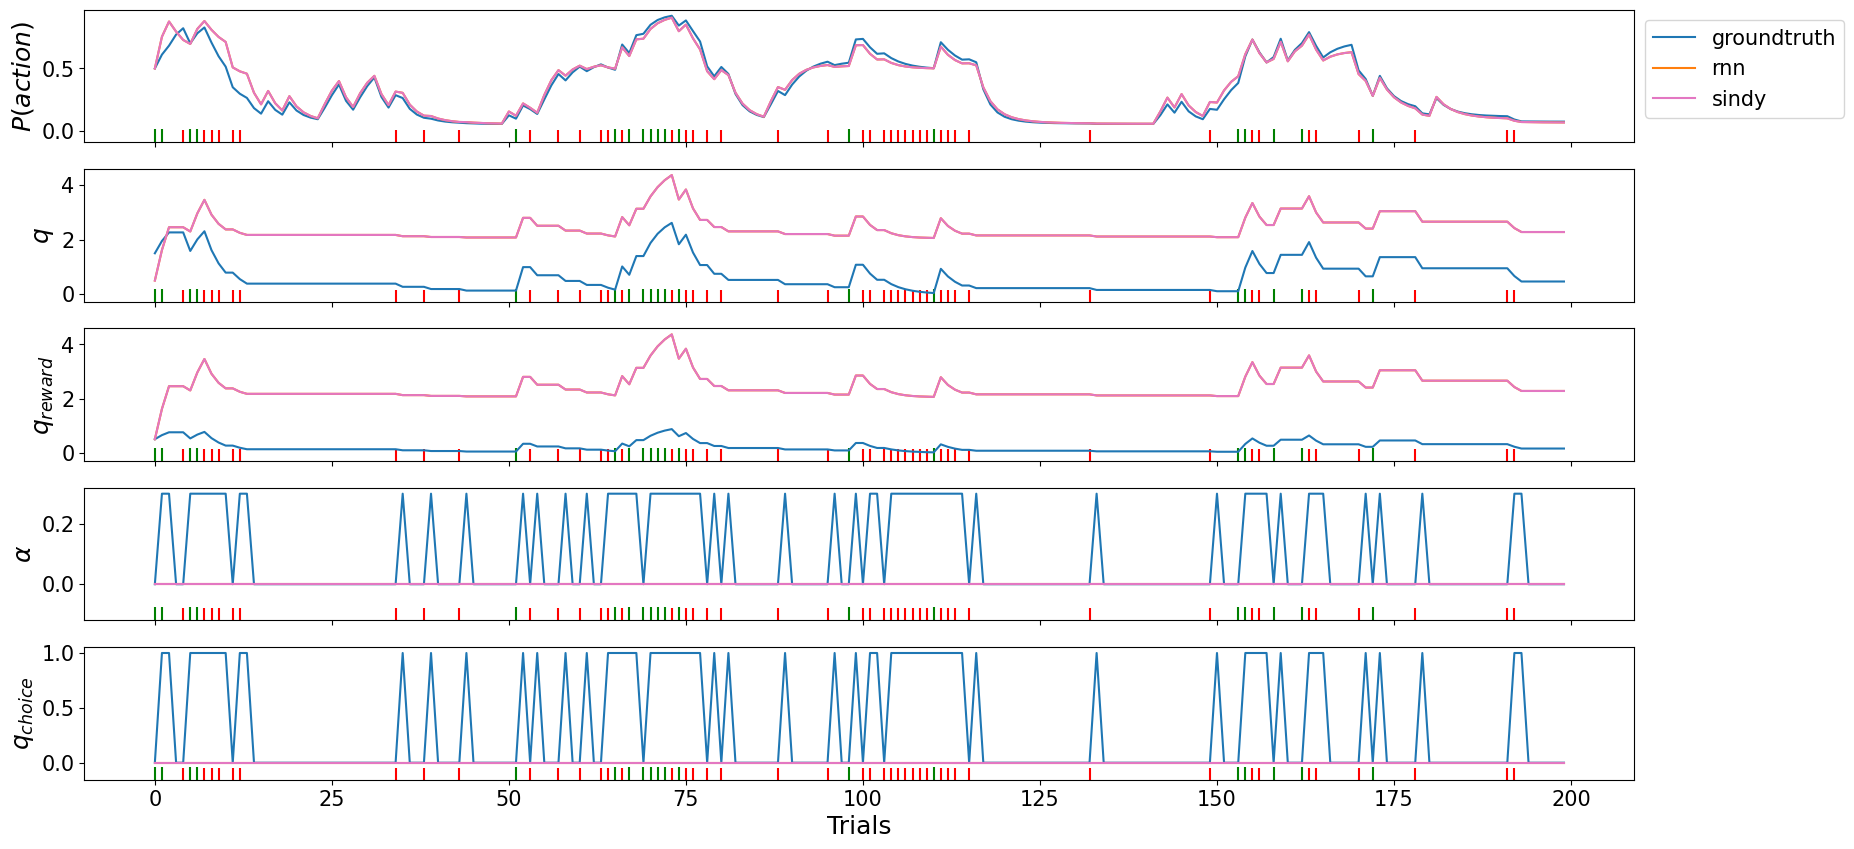

In [15]:
# get analysis plot
agents = {'groundtruth': agent, 'rnn': agent_rnn, 'sindy': agent_sindy}

fig, axs = plot_session(agents, experiments[0])
plt.show()

How does the fit look like? Does the equation which you received by SINDy makes any sense? If so, we discovered our first model of cognition!

We could now dive deeper into **computational discovery of cognitive dynamics**.

Try to set up a more complex version of the synthetic participant by adding e.g. a forget mechanism with `forget_rate=0.2`, and run the whole pipeline again. 

Forgetting is applied to the not-chosen reward-based value `x_value_reward`, where it resets the value gradually towards the initial value (0.5)  

What do you notice?

The fit should be decreased now. Mostly because the RNN does not have the ability to fit any dynamics to the not-chosen option.

Let's implement a more complex RNN which can cover this part as well.

# 4. Adding more RNN-modules

Here we are adding a RNN-module which handles the not-chosen reward-based values dynamically.

This should enable the RNN to learn a forgetting mechanism, which is present in the data.

In [16]:
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.3,
    forget_rate=0.,
)

dataset, experiments, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

# SINDy configuration
# Add already here the new module and update the library and filter setup.
list_variables = ['x_value_reward_chosen', 'x_value_reward_not_chosen']

list_control_parameters = ['c_action', 'c_reward']

# The new module which handles the not-chosen value, does not need any additional inputs except for the value
library_setup = {
    'x_value_reward_chosen': ['c_reward'],
    'x_value_reward_not_chosen': [],
}

# Further, the new module should be applied only to the not-chosen values
filter_setup = {
    'x_value_reward_chosen': ['c_action', 1, True],
    'x_value_reward_not_chosen': ['c_action', 0, True],
}

In [17]:
class RLRNN(BaseRNN):
    
    init_values = {
        'x_value_reward': 0.5,
    }
    
    def __init__(
        self,
        n_actions,
        list_signals,
        **kwargs,
    ):
        super(RLRNN, self).__init__(n_actions=n_actions, hidden_size=8, list_signals=list_signals)
        
        # set up the submodules
        self.submodules_rnn['x_value_reward_chosen'] = self.setup_module(input_size=2, hidden_size=self._hidden_size, dropout=0.)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=1, hidden_size=self._hidden_size, dropout=0.)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _ = inputs
        
        value_reward = self.get_state()['x_value_reward']
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # Let's perform the belief update for the reward-based value of the chosen option
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state=value_reward,
                action=action,
                inputs=reward,
                )

            # Now a RNN-module updates the not-chosen reward-based value instead of keeping it the same
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state=value_reward,
                action=1-action,
                inputs=None,
                )
            
            # keep track of the updated value in the memory state
            value_reward = next_value_reward_chosen + next_value_reward_not_chosen
            
            # Now keep track of this value in the output array
            logits[timestep] = value_reward
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        self.state['x_value_reward'] = value_reward
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

Epoch 1/128 --- L(Training): 6.9944546; Time: 0.11s; Convergence value: 3.50e+00
Epoch 2/128 --- L(Training): 0.9593319; Time: 0.11s; Convergence value: 4.77e+00
Epoch 3/128 --- L(Training): 1.4467056; Time: 0.11s; Convergence value: 2.63e+00
Epoch 4/128 --- L(Training): 0.7729749; Time: 0.11s; Convergence value: 1.65e+00
Epoch 5/128 --- L(Training): 0.6238185; Time: 0.11s; Convergence value: 9.00e-01
Epoch 6/128 --- L(Training): 0.6033890; Time: 0.11s; Convergence value: 4.60e-01
Epoch 7/128 --- L(Training): 0.5982453; Time: 0.13s; Convergence value: 2.33e-01
Epoch 8/128 --- L(Training): 0.5934740; Time: 0.13s; Convergence value: 1.19e-01
Epoch 9/128 --- L(Training): 0.5893018; Time: 0.22s; Convergence value: 6.14e-02
Epoch 10/128 --- L(Training): 0.5852578; Time: 0.12s; Convergence value: 3.27e-02
Epoch 11/128 --- L(Training): 0.5813033; Time: 0.13s; Convergence value: 1.83e-02
Epoch 12/128 --- L(Training): 0.5774611; Time: 0.12s; Convergence value: 1.11e-02
Epoch 13/128 --- L(Traini

/home/daniel/miniconda3/envs/rl/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 5.5966e-28 ... 2.5000e-02 ... 2.5000e-02 ... 2.7500e-02
         3 ... 2.9038e-03 ... 3.9394e-02 ... 2.6736e-02 ... 3.3580e-02
         6 ... 9.5109e-03 ... 5.8052e-02 ... 2.7499e-02 ... 4.2815e-02
         9 ... 1.5250e-02 ... 7.2673e-02 ... 2.7949e-02 ... 5.0466e-02
        12 ... 1.9282e-02 ... 8.2574e-02 ... 2.8216e-02 ... 5.5755e-02
        15 ... 2.1891e-02 ... 8.8868e-02 ... 2.8373e-02 ... 5.9150e-02
        18 ... 2.3511e-02 ... 9.2743e-02 ... 2.8466e-02 ... 6.1251e-02
        21 ... 2.4496e-02 ... 9.5088e-02 ... 2.8521e-02 ... 6.2526e-02
        24 ... 2.5089e-02 ... 9.6493e-02 ... 2.8554e-02 ... 6.3292e-02
        27 ... 2.5442e-02 ... 9.7330e-02 ... 2.8573e-02 ... 6.3748e-02
(x_value_reward_not_chosen)[k+1] = 1.000 x_value_reward_not_chosen[k]


/home/daniel/miniconda3/envs/rl/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


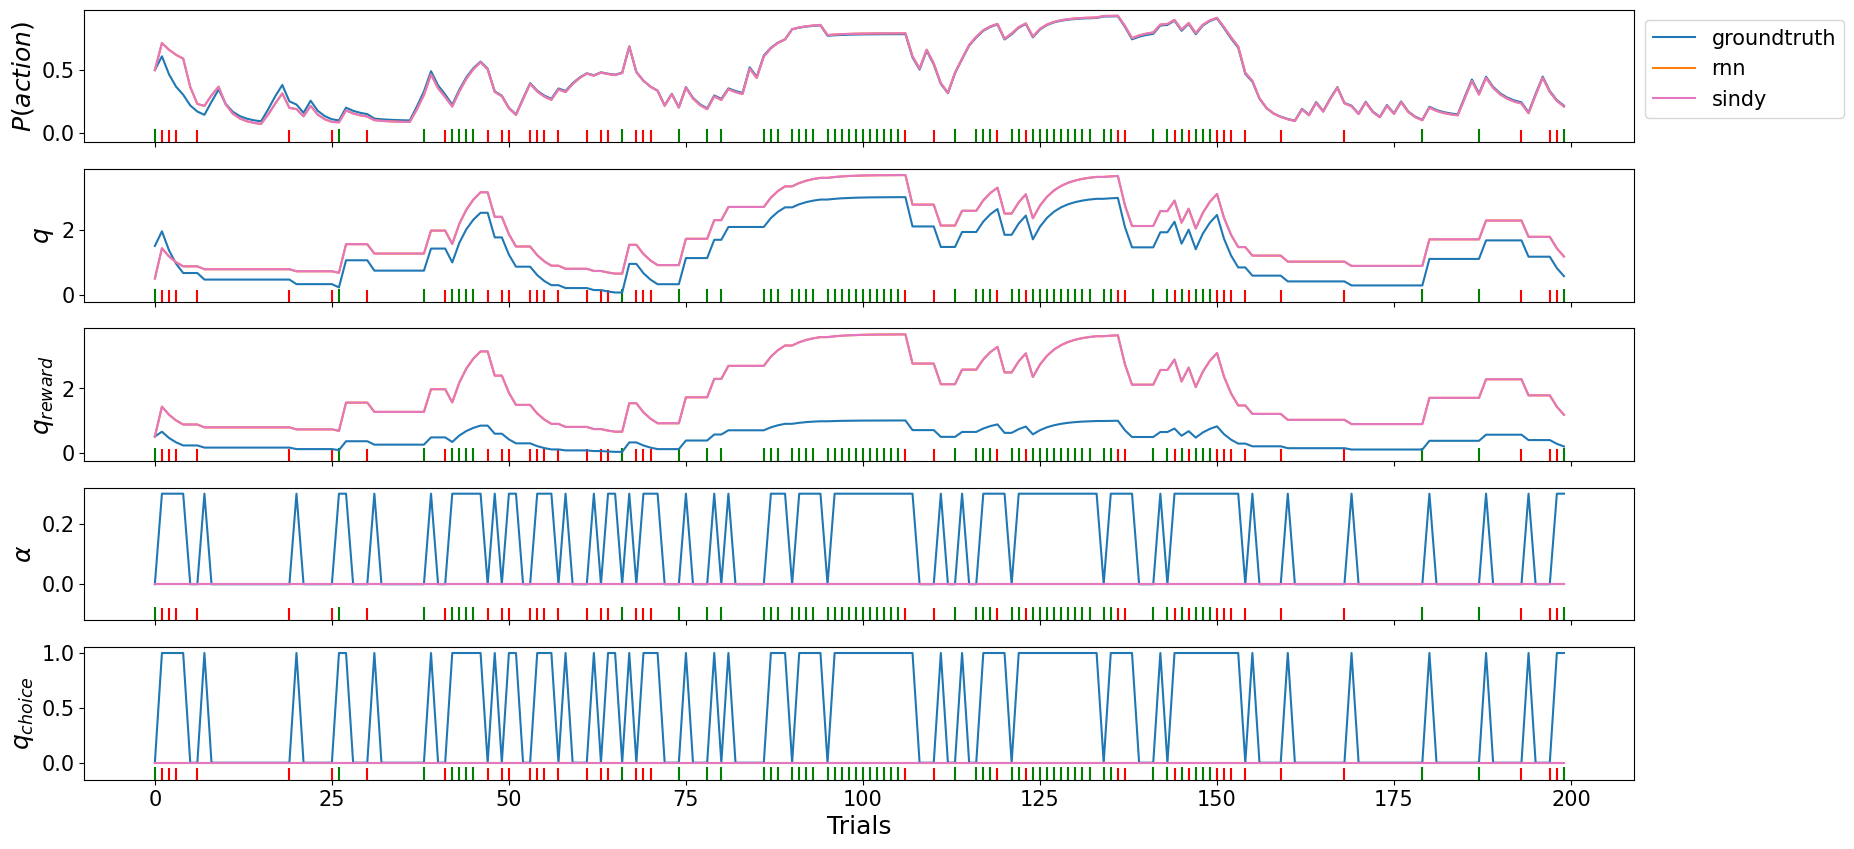

In [18]:
model_rnn = RLRNN(n_actions=n_actions, list_signals=list_variables+list_control_parameters)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-3)

model_rnn, _, _ = fit_model(
    model=model_rnn,
    optimizer=optimizer_rnn,
    dataset_train=dataset,
    epochs=128,
    n_steps=16,
)

# set up RNN-agent
agent_rnn = AgentNetwork(model_rnn=model_rnn, n_actions=n_actions)

# extract all necessary data from the RNN (memory state) and align with the control inputs (action, reward)
variables, control_parameters, feature_names, _ = create_dataset_sindy(
    agent=agent_rnn,
    data=environment,
    n_sessions=1,
    n_trials=1024,
    participant_id=0,
)

# fit one SINDy-model per RNN-module
sindy_models = fit_model_sindy(
    variables=variables,
    control=control_parameters,
    feature_names=feature_names,
    polynomial_degree=2,
    library_setup=library_setup,
    filter_setup=filter_setup,
    verbose=True,
)

# set up a SINDy-based agent by replacing the RNN-modules with the respective SINDy-model
agent_sindy = AgentSindy(model_rnn=model_rnn, sindy_modules=sindy_models, n_actions=n_actions)

# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent, 'rnn': agent_rnn, 'sindy': agent_sindy}
fig, axs = plot_session(agents, experiments[0])
plt.show()

As you maybe noticed, the steps did not change dramatically thanks to the more-or-less seemless workflow.

The current RNN should also be able to handle asymmetric learning rates. Try it by setting the parameters `alpha_reward=0.6` and `alpha_penalty=0.3`. 

That way our synthetic participant will adapt its beliefs more when it receives a reward ($reward = 1$) compared to a penalty ($reward = 0$).

## 6. Adding hard-coded equations as RNN-modules and additional memory states

The equation for `x_reward_value_chosen` resembles basically the reward-prediction error.

The reward-prediction error is fairly well understood in cognitive science - also thanks to neuroimaging studies, which underlie the assumption about the classic mathematical form.

Therefore, the possible novel findings are quite limited here. 
The learning rate on the other hand is in many studies assumed to be a constant and is also embedded in the SINDy equation as a fixed parameter. 
It can of course model asymmetric learning rates for rewards and penalties but is not adapting dynamically. 

So what if we would like to find a dynamical equation which describes how the learning rate could possibly change with respect to rewards or the current value `x_reward_value_chosen`? 

The problem here is that we cannot just add another RNN-module in-line with `x_reward_value_chosen` which processes the same inputs.

This would result in two modules which would not have unique solutions.

Therefore, we have to disentangle here by adding knowledge about `x_reward_value_chosen` in the form of the classic reward-prediction error.

That way we are ending up with an additional RNN-module in the form of a hard-coded equation, and we have to expand the memory state by one variable which is the learning rate `x_learning_rate_reward`. 

Additionally, we are going to set the initial values for all memory state variables.

In the next section you will learn how to add hard-coded equations to the RNN.

In [19]:
class RLRNN(BaseRNN):
    
    # add an additional memory state by defining a new initial value for that state
    init_values = {
            'x_value_reward': 0.5,
            'x_learning_rate_reward': 0,
        }
    
    def __init__(
        self,
        n_actions,
        list_signals,
        **kwargs,
    ):
        
        super(RLRNN, self).__init__(n_actions=n_actions, hidden_size=8, list_signals=list_signals)
        
        # set up the submodules
        # switch from 'x_value_reward_chosen' to 'x_learning_rate_reward' to compute the learning rate based on the current reward-based value and the reward
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=3, hidden_size=self._hidden_size, dropout=0.)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=1, hidden_size=self._hidden_size, dropout=0.)
        
        # set up hard-coded equations
        # add here a RNN-module in the form of an hard-coded equation to compute the update for the chosen reward-based value
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)
        
        # add a scaling factor (inverse noise temperature) for value_reward
        self.betas = torch.nn.ParameterDict()
        self.betas['x_value_reward'] = torch.nn.Parameter(torch.tensor(1.))
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _ = inputs
        
        # retrieve all memory states
        value_reward = self.get_state()['x_value_reward']
        learning_rate_reward = self.get_state()['x_learning_rate_reward']
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # Let's compute the learning rate dynamically
            # We can constrain the learning rate to a range of (0, 1) to enforce valid updates
            # Otherwise it is quite probable that we encounter exploding gradients
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state=learning_rate_reward,
                action=action,
                inputs=(reward, value_reward),
                # inputs=None,
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # Let's perform the belief update for the reward-based value of the chosen option            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state=value_reward,
                action=action,
                inputs=(reward, learning_rate_reward),
                )
            
            # Update of the not-chosen reward-based value
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state=value_reward,
                action=1-action,
                inputs=None,
                )
            
            value_reward = (next_value_reward_chosen * self.betas['x_value_reward'] + next_value_reward_not_chosen)
            
            # Now keep track of this value in the output array
            logits[timestep] = value_reward
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', value_reward)
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        self.state['x_value_reward'] = value_reward
        self.state['x_learning_rate_reward'] = learning_rate_reward
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

In [23]:
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.6,
    alpha_penalty=0.3,
    forget_rate=0.,
    confirmation_bias=0.8,
)

dataset, experiments, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

# SINDy configuration
# Add already here the new module and update the library and filter setup.
list_variables = ['x_value_reward_chosen', 'x_value_reward_not_chosen', 'x_learning_rate_reward']
# list_variables = ['x_value_reward_chosen', 'x_learning_rate_reward']

# add here a control parameter for the reward-based value which serves as an additional input to the learning-rate
list_control_parameters = ['c_action', 'c_reward', 'c_value_reward']

# The new module which handles the not-chosen value, does not need any additional inputs except for the value
library_setup = {
    # 'x_value_reward_chosen': ['c_reward'] -> Remove this one from the library as we are not going to identify the dynamics of a hard-coded equation
    'x_learning_rate_reward': ['c_reward', 'c_value_reward'],
    'x_value_reward_not_chosen': [],
    }

# Further, the new module should be applied only to the not-chosen values
filter_setup = {
    # 'x_value_reward_chosen': ['c_action', 1, True], -> Remove this one as well
    'x_learning_rate_reward': ['c_action', 1, True],
    'x_value_reward_not_chosen': ['c_action', 0, True],
}

Epoch 1/1024 --- L(Training): 1.6509339; Time: 0.16s; Convergence value: 8.25e-01; LR: 0.00e+00
Epoch 2/1024 --- L(Training): 0.8562875; Time: 0.15s; Convergence value: 8.10e-01; LR: 3.91e-05
Epoch 3/1024 --- L(Training): 0.8458559; Time: 0.23s; Convergence value: 4.10e-01; LR: 7.81e-05
Epoch 4/1024 --- L(Training): 0.8274609; Time: 0.27s; Convergence value: 2.14e-01; LR: 1.17e-04
Epoch 5/1024 --- L(Training): 0.7995975; Time: 0.22s; Convergence value: 1.21e-01; LR: 1.56e-04
Epoch 6/1024 --- L(Training): 0.7572682; Time: 0.17s; Convergence value: 8.17e-02; LR: 1.95e-04
Epoch 7/1024 --- L(Training): 0.6812271; Time: 0.18s; Convergence value: 7.89e-02; LR: 2.34e-04
Epoch 8/1024 --- L(Training): 0.6830901; Time: 0.15s; Convergence value: 4.04e-02; LR: 2.73e-04
Epoch 9/1024 --- L(Training): 0.6890826; Time: 0.15s; Convergence value: 2.32e-02; LR: 3.13e-04
Epoch 10/1024 --- L(Training): 0.6883710; Time: 0.22s; Convergence value: 1.19e-02; LR: 3.52e-04
Epoch 11/1024 --- L(Training): 0.684240

/home/daniel/miniconda3/envs/rl/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


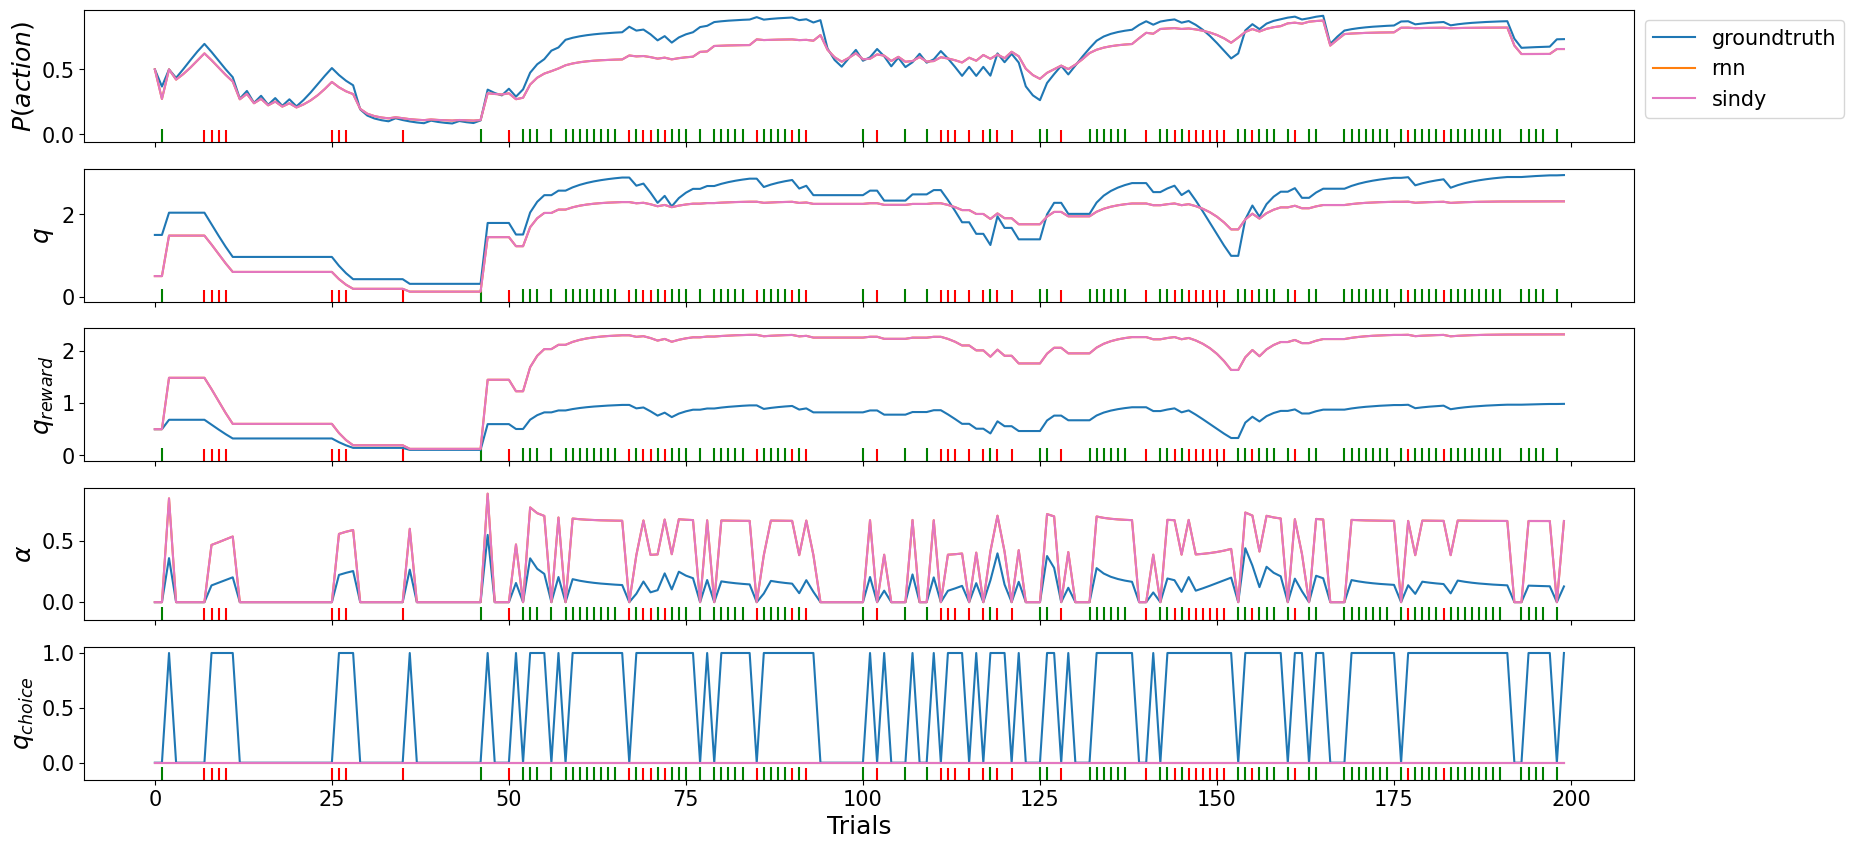

In [ ]:
model_rnn = RLRNN(n_actions=n_actions, list_signals=list_variables+list_control_parameters)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-3)

model_rnn, _, _ = fit_model(
    model=model_rnn,
    optimizer=optimizer_rnn,
    dataset_train=dataset,
    epochs=1024,
    n_steps=16,
    scheduler=True,
)

# set up RNN-agent
agent_rnn = AgentNetwork(model_rnn=model_rnn, n_actions=n_actions)

# extract all necessary data from the RNN (memory state) and align with the control inputs (action, reward)
variables, control_parameters, feature_names, _ = create_dataset_sindy(
    agent=agent_rnn,
    data=environment,
    n_sessions=1,
    n_trials=1024,
    participant_id=0,
)

# fit one SINDy-model per RNN-module
sindy_models = fit_model_sindy(
    variables=variables,
    control=control_parameters,
    feature_names=feature_names,
    polynomial_degree=2,
    library_setup=library_setup,
    filter_setup=filter_setup,
    verbose=True,
)

# set up a SINDy-based agent by replacing the RNN-modules with the respective SINDy-model
agent_sindy = AgentSindy(model_rnn=model_rnn, sindy_modules=sindy_models, n_actions=n_actions)

# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent, 'rnn': agent_rnn, 'sindy': agent_sindy}
fig, axs = plot_session(agents, experiments[0])
plt.show()

Now that we are making use of the established theories about the reward-prediction error in human reinforcement learning, we were able to to shift our focus on a less understood area i.e. the learning rate. In this example, the synthetic participant does not exhibit real dynamics in the sense of $\alpha_{t+1} = f(\alpha_{t})$, but the network is in principle equipped to learn also such a mechanism.

We could now even further extend the capabilities of the RNN by making it sensitive to individual differences!

Let's take a look on how to implement that!

# 7. Tackling individual differences

By individual differences cognitive scientists are referring to individual notions in exhibited behavior, e.g. different learning rates.

But this thought can go even deeper if we not only consider different parameterizations for each participant but also different model architectures for each participant!

Think of e.g. one participant exhibits only goal-directed behavior (i.e. making choices based only on the reward-based values) while another participant shows a ..... (to be continued)